In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from pmdarima import auto_arima



In [2]:
df=pd.read_csv('Erathna_project.csv')
df.head()



,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max
0,2010,January,130.2,22.1,32.1,NaN,NaN
1,2010,February,41.3,22.6,33.9,NaN,NaN
2,2010,March,171.5,23.1,35.2,NaN,NaN
3,2010,April,421.7,23.7,33.5,NaN,NaN
4,2010,May,793.3,24.0,31.8,NaN,NaN


In [3]:
df["Time"]=df["Year"].astype(str)+"-"+df["Month"].astype(str)



In [4]:
df.head()



,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Time
0,2010,January,130.2,22.1,32.1,NaN,NaN,2010-January
1,2010,February,41.3,22.6,33.9,NaN,NaN,2010-February
2,2010,March,171.5,23.1,35.2,NaN,NaN,2010-March
3,2010,April,421.7,23.7,33.5,NaN,NaN,2010-April
4,2010,May,793.3,24.0,31.8,NaN,NaN,2010-May


In [5]:
#Slicing dataset
temperature_max=df[["Time","Temp_max"]]
temperature_max.head()



,Time,Temp_max
0,2010-January,32.1
1,2010-February,33.9
2,2010-March,35.2
3,2010-April,33.5
4,2010-May,31.8


In [6]:
temperature_max['Time']=pd.to_datetime(temperature_max['Time'])



<ipython-input-6-be289abb8a7e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature_max['Time']=pd.to_datetime(temperature_max['Time'])


In [7]:
temperature_max.head()


,Time,Temp_max
0,2010-01-01,32.1
1,2010-02-01,33.9
2,2010-03-01,35.2
3,2010-04-01,33.5
4,2010-05-01,31.8


In [8]:
#Checking for missing values
temperature_max.isna().sum()

Time        0
Temp_max    1
dtype: int64

In [9]:
#Setting the time index
temperature_max.set_index('Time',inplace=True)

In [10]:
temperature_max=temperature_max.resample('MS').first()

In [11]:
#removing missing values
temp=temperature_max.fillna(method='ffill')
temp.head(20)

,Temp_max
Time,
2010-01-01,32.1
2010-02-01,33.9
2010-03-01,35.2
2010-04-01,33.5
2010-05-01,31.8
2010-06-01,30.9
2010-07-01,30.8
2010-08-01,30.3
2010-09-01,30.9


In [12]:
#Checking for missing values
temp.isna().sum()

Temp_max    0
dtype: int64

In [13]:
#Rename column
temp = temp.rename(columns = {'Temp_max': 'Temperature Max'}, inplace = False)
temp.head()


,Temperature Max
Time,
2010-01-01,32.1
2010-02-01,33.9
2010-03-01,35.2
2010-04-01,33.5
2010-05-01,31.8


In [14]:
#Checking for missing values
temp.isna().sum()

Temperature Max    0
dtype: int64

<AxesSubplot:xlabel='Time'>

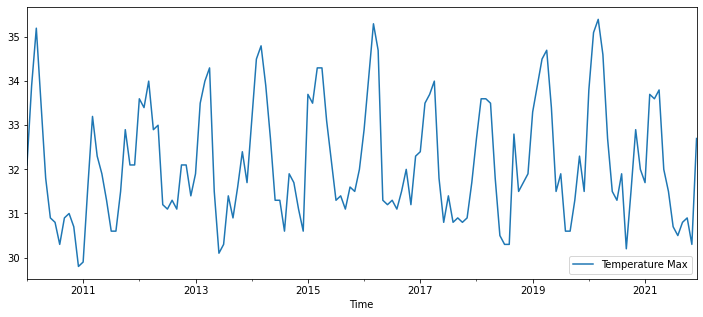

In [15]:
temp.plot(figsize=(12,5))


It can't be cleary identified trend. But there is some evidence for seasonality.

In [16]:
### ADF Test
test_result=adfuller(temp['Temperature Max'])
#Ho: The series is non stationary
#H1: The series is stationary

def adfuller_test(rainfall):
    result=adfuller(rainfall)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(temp['Temperature Max'])


ADF Test Statistic : -3.5492824152779257
p-value : 0.006808034916096019
#Lags Used : 14
Number of Observations Used : 129
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [17]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(temp['Temperature Max'])


KPSS Statistic: 0.05817737768070886
p-value: 0.1
num lags: 5
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\isuru\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [18]:
#PhillipsPerron Test
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(temp['Temperature Max'].astype(float))
print(pp.summary().as_text())


     Phillips-Perron Test (Z-tau)    
Test Statistic                 -3.987
P-value                         0.001
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# ACF and PACF plots

C:\Users\isuru\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


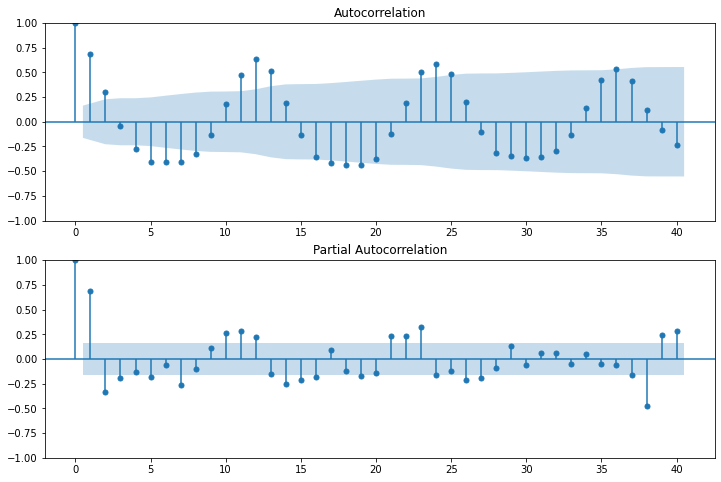

In [19]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(temp['Temperature Max'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(temp['Temperature Max'],lags=40,ax=ax2)


According to the PACF and ACF plots, series is likely to follow a MA process. But since we are following step-wise, better to start with p=2,q=3, d=0

In [20]:
arima_model=auto_arima(temp['Temperature Max'].astype(float),start_p=0,start_q=0,max_p=4,max_q=5,start_P=0,start_Q=0,max_P=2,max_Q=3,m=12,seasonal=True,error_action='warn',trace=True,supress_warnings=True,stepwise=False,random_state=20,n_fits=70,maxiter=70,information_criterion='aic')



 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=496.940, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=451.689, Time=0.31 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=426.916, Time=0.96 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=424.093, Time=2.10 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=403.473, Time=1.76 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=423.588, Time=6.34 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=397.410, Time=8.68 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=4.60 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=9.59 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=7.61 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=425.293, Time=9.98 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=422.447, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=392.669, Time=0.15 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=383.704, Time=0.81 sec
 ARIMA(0,0,1)(0,0,3)[12] i

C:\Users\isuru\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,0)(2,0,1)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=7.88 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=398.330, Time=0.34 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=375.286, Time=0.97 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=372.762, Time=2.44 sec
 ARIMA(1,0,1)(0,0,3)[12] intercept   : AIC=369.766, Time=7.16 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=1.83 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.94 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=7.01 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=356.783, Time=5.45 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=9.46 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=395.892, Time=0.74 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=375.605, Time=1.57 sec
 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=374.011, Time=7.40 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=1.68 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : 

C:\Users\isuru\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(4,0,0)(1,0,0)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(4,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(4,0,1)(0,0,0)[12] intercept   : AIC=388.424, Time=0.76 sec

Best model:  ARIMA(1,0,0)(1,0,3)[12] intercept
Total fit time: 342.562 seconds


In [21]:
model=sm.tsa.statespace.SARIMAX(temp['Temperature Max'].astype('float'),order=(1, 0, 0),seasonal_order=(1,0,3,12))
results=model.fit()
results.summary()



C:\Users\isuru\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                            Temperature Max   No. Observations:                  144
Model:             SARIMAX(1, 0, 0)x(1, 0, [1, 2, 3], 12)   Log Likelihood                -182.036
Date:                                    Thu, 14 Apr 2022   AIC                            376.072
Time:                                            00:14:56   BIC                            393.891
Sample:                                        01-01-2010   HQIC                           383.313
                                             - 12-01-2021                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9907      0.013     78.791      0.000       0.966       1.015
ar.S.L12       0.9833      0.020     50.190      0.000       0.945       1.022
ma.S.L12      -0.8479      0.116     -7.293      0.000      -1.076      -0.620
ma.S.L24      -0.1985      0.115     -1.719      0.086      -0.425       0.028
ma.S.L36       0.2420      0.096      2.510      0.012       0.053       0.431
sigma2         0.6151      0.072      8.551      0.000       0.474       0.756
===================================================================================
Ljung-Box (L1) (Q):                   9.44   Jarque-Bera (JB):                 2.64
Prob(Q):                              0.00   Prob(JB):                         0.27
Heteroskedasticity (H):               1.37   Skew:                             0.18
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Time'>

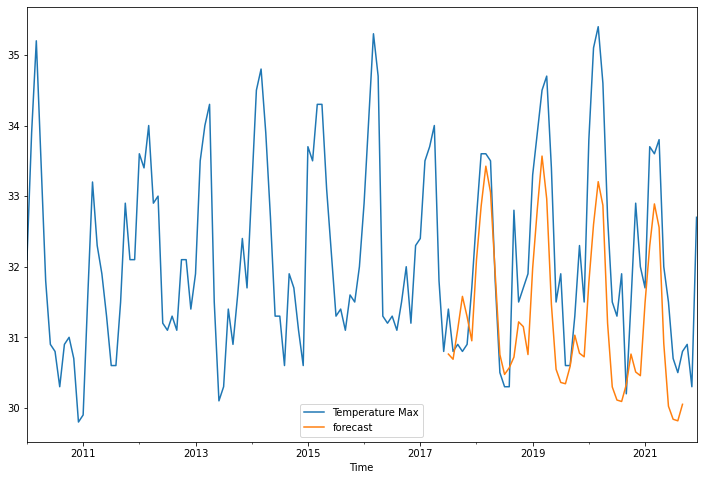

In [22]:
temp['forecast']=results.predict(start=90,end=140,dynamic=True)
temp[['Temperature Max','forecast']].plot(figsize=(12,8))





In [24]:
temp.tail()



,Temperature Max,forecast
Time,,
2021-08-01,30.5,29.379179
2021-09-01,30.8,29.341740
2021-10-01,30.9,29.554796
2021-11-01,30.3,NaN
2021-12-01,32.7,NaN


In [25]:
results.predict(start=200,end=205,dynamic=True)




C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


200    30.975184
201    31.132630
202    31.226613
203    31.532509
204    32.556172
205    32.994867
Name: predicted_mean, dtype: float64